In [1]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_density, facet_wrap, theme_bw, labs, theme, geom_vline
from sklearn.model_selection import train_test_split
from funs import dataPreparation, createMetaDictionary, createDictionary, evaluateModel

In [2]:
# Prepare the data

data = dataPreparation(all_trxns_path = "../all_trxns.csv", exchange_rates_path = "../exchange_rates.csv")

# Split the data into training and testing sets
X = data
y = data['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
# Create dictionaries with Fraud probability

# meaning check historical fraud probability for each value of the variable

dictionaries_to_get = ['customer_country', 'counterparty_country', 'type', 'ccy', 'customer_type', 'weekday', 'month', 'quarter', 'hour', 'amount_eur_bucket']

dictionaries = {}
for dict_name in dictionaries_to_get:
    dictionaries[dict_name] = createDictionary(X_train,
                                                colname=dict_name,
                                                count_filter=0)

In [ ]:
# Create meta dictionary with Fraud probability thresholds

# meaning find the limits for the historical fraud probability for each variable

meta_dictionary = pd.DataFrame()
for dict_name in dictionaries_to_get:
    meta_dictionary = meta_dictionary.append(createMetaDictionary(X_train,
                                                                  colname=dict_name,
                                                                  quantile_threshold=.9,
                                                                  count_filter=0))

In [10]:
# Define the model

# Join and transform the data
# Get the data from dictionaries and meta dictionary

joined_data = (X_train
               .merge(dictionaries['customer_country'], on='customer_country')
               .merge(dictionaries['counterparty_country'], on='counterparty_country')
               .merge(dictionaries['type'], on='type')
               .merge(dictionaries['ccy'], on='ccy')
               .merge(dictionaries['customer_type'], on='customer_type')
               .merge(dictionaries['weekday'], on='weekday')
               .merge(dictionaries['month'], on='month')
               .merge(dictionaries['quarter'], on='quarter')
               .merge(dictionaries['hour'], on='hour')
               .merge(dictionaries['amount_eur_bucket'], on='amount_eur_bucket')
               .loc[:, ['timestamp', 'customer', 'counterparty', 'customer_country_value',
                        'counterparty_country_value', 'type_value', 'ccy_value',
                        'customer_type_value', 'weekday_value', 'month_value',
                        'quarter_value', 'hour_value', 'amount_eur_bucket_value']])

joined_data = (joined_data
               .melt(id_vars=['timestamp', 'customer', 'counterparty'], 
                     value_vars=['customer_country_value', 'counterparty_country_value', 'type_value',
                                 'ccy_value', 'customer_type_value', 'weekday_value', 'month_value',
                                 'quarter_value', 'hour_value', 'amount_eur_bucket_value'])
               .dropna(subset=['value'])
               .assign(name=lambda x: x['variable'].str.replace('_value', ''))
               .merge(meta_dictionary, left_on='name', right_on='variable_name')
               .drop(columns=['variable_name', 'variable']))

joined_data_aggregated = (joined_data
          .assign(sd_flag=lambda x: np.where(x['value'] > x['sd_flag'], 1, 0))
          .assign(quantile_flag=lambda x: np.where(x['value'] > x['q_flag'], 1, 0))
          .groupby(['timestamp', 'customer', 'counterparty'])
          .agg(expected_fraud_probability=('value', 'sum'), sd_flags=('sd_flag', 'sum'), quantile_flags=('quantile_flag', 'sum'))
          .reset_index()
         )

In [11]:
# Evaluate the training model
training_set = (joined_data_aggregated
             .merge(X_train[['timestamp', 'customer', 'counterparty', 'fraud_flag']], on=['timestamp', 'customer', 'counterparty'], how='left')
            )   

In [7]:
print("Mean Expected Fraud Probability: ", training_set['expected_fraud_probability'].mean().round(4))

Mean Expected Fraud Probability:  0.1769


In [12]:
grouped_data = training_set.groupby('fraud_flag').agg(mean_value=('expected_fraud_probability', 'mean'),
                                                     q2_value=('expected_fraud_probability', lambda x: x.quantile(.2)),
                                                     q9_value=('expected_fraud_probability', lambda x: x.quantile(.9)),
                                                     sd_flags=('sd_flags', 'sum'),
                                                     quantile_flags=('quantile_flags', 'sum'),
                                                     n=('expected_fraud_probability', 'count'))
grouped_data['sd_mean_flags'] = grouped_data['sd_flags'] / grouped_data['n']
grouped_data['quantile_mean_flags'] = grouped_data['quantile_flags'] / grouped_data['n']
grouped_data = grouped_data.reset_index()

In [13]:
# Perform the analysis to find the best thresholds for expected_fraud_probability, sd_flags and quantile_flags

grouped_data

,fraud_flag,mean_value,q2_value,q9_value,sd_flags,quantile_flags,n,sd_mean_flags,quantile_mean_flags
0,N,0.172287,0.136287,0.224298,5471,6833,3895,1.404621,1.754300
1,Y,0.423953,0.189046,0.366388,464,496,73,6.356164,6.794521


c:\Users\Mateusz\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


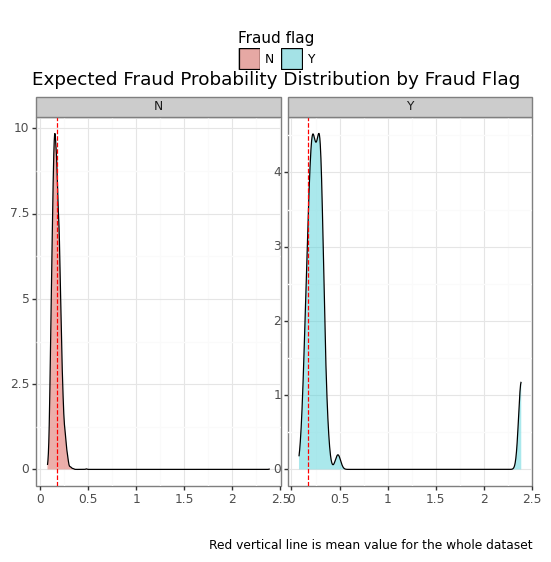

<ggplot: (110871197273)>

In [14]:
(ggplot(training_set, aes(x='expected_fraud_probability', fill='fraud_flag')) +
 geom_density(alpha=.5) +
 facet_wrap('~ fraud_flag', scales='free_y') +
 theme_bw() +
 labs(title='Expected Fraud Probability Distribution by Fraud Flag',
      x = '',
      y = '',
      fill = 'Fraud flag',
      caption = 'Red vertical line is mean value for the whole dataset') +
 theme(legend_position='top') +
 geom_vline(xintercept=training_set['expected_fraud_probability'].mean(), color='red', linetype='dashed', size=.5)
)

# This looks promissing
# the distribution of the expected_fraud_probability is different for fraud and non-fraud transactions, it is shifted to the right for fraud transactions

In [16]:
print("Mean of sd_flags: ", training_set['sd_flags'].mean().round(2))

Mean of sd_flags:  1.5


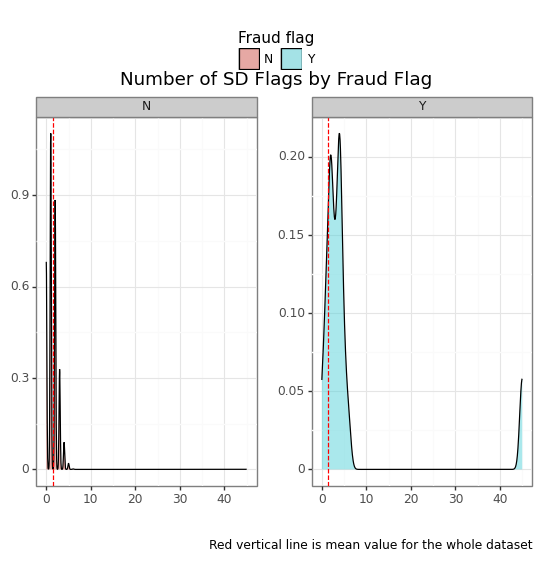

<ggplot: (110871178400)>

In [17]:
(ggplot(training_set, aes(x='sd_flags', fill='fraud_flag')) +
 geom_density(alpha=.5) +
 facet_wrap('~ fraud_flag', scales='free_y') +
 theme_bw() +
 labs(title='Number of SD Flags by Fraud Flag',
      x = '',
      y = '',
      fill = 'Fraud flag',
      caption = 'Red vertical line is mean value for the whole dataset') +
 theme(legend_position='top',
       subplots_adjust={'wspace': .25}) +
 geom_vline(xintercept=training_set['sd_flags'].mean(), color='red', linetype='dashed', size=.5)
)

# This could also be a good indicator

In [18]:
print("Mean of quantile flags: ", training_set['quantile_flags'].mean().round(2))

Mean of quantile flags:  1.85


c:\Users\Mateusz\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


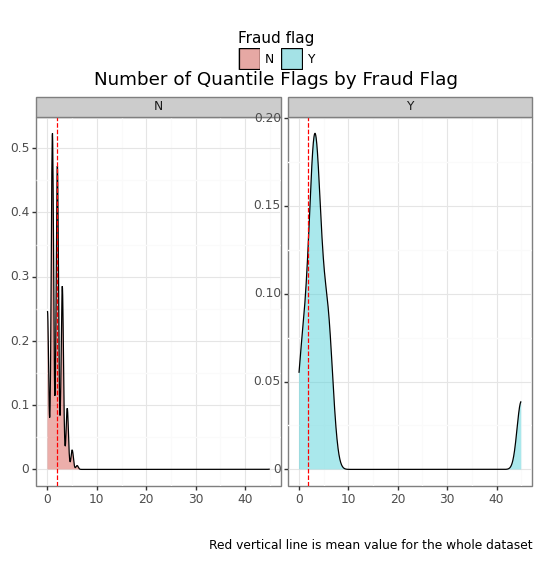

<ggplot: (110872431187)>

In [19]:
(ggplot(training_set, aes(x='quantile_flags', fill='fraud_flag')) +
 geom_density(alpha=.5) +
 facet_wrap('~ fraud_flag', scales='free_y') +
 theme_bw() +
 labs(title='Number of Quantile Flags by Fraud Flag',
      x = '',
      y = '',
      fill = 'Fraud flag',
      caption = 'Red vertical line is mean value for the whole dataset') +
 theme(legend_position='top') +
 geom_vline(xintercept=training_set['quantile_flags'].mean(), color='red', linetype='dashed', size=.5)
)

# This could also be a good indicator

In [20]:
# Set the thresholds for expected_fraud_probability, sd_flags and quantile_flags

result = joined_data_aggregated.assign(predicted_fraud = np.where((joined_data_aggregated['expected_fraud_probability'] > 0.18) & 
                                                                  (joined_data_aggregated['sd_flags'] > 1) & 
                                                                  (joined_data_aggregated['quantile_flags'] > 1), 1, 0))

In [21]:
# Evaluate the train model

train_model = (X_train[['timestamp', 'customer', 'counterparty', 'fraud_flag']]
             .merge(result, on=['timestamp', 'customer', 'counterparty'], how='left'))

train_model_prediction = train_model.groupby(['fraud_flag', 'predicted_fraud']).agg(mean_value=('expected_fraud_probability', 'mean'),
                                                     q2_value=('expected_fraud_probability', lambda x: x.quantile(.2)),
                                                     q9_value=('expected_fraud_probability', lambda x: x.quantile(.9)),
                                                     sd_flags=('sd_flags', 'sum'),
                                                     quantile_flags=('quantile_flags', 'sum'),
                                                     n=('expected_fraud_probability', 'count'))
train_model_prediction['sd_mean_flags'] = train_model_prediction['sd_flags'] / train_model_prediction['n']
train_model_prediction['quantile_mean_flags'] = train_model_prediction['quantile_flags'] / train_model_prediction['n']
train_model_prediction = train_model_prediction.reset_index()

train_model_prediction

,fraud_flag,predicted_fraud,mean_value,q2_value,q9_value,sd_flags,quantile_flags,n,sd_mean_flags,quantile_mean_flags
0,N,0.0,0.152509,0.128999,0.185527,2451.0,3334.0,2751,0.890949,1.211923
1,N,1.0,0.219847,0.193598,0.257672,3020.0,3499.0,1144,2.639860,3.058566
2,Y,0.0,0.161386,0.146287,0.190613,11.0,14.0,14,0.785714,1.000000
3,Y,1.0,0.486257,0.221471,0.864275,453.0,482.0,59,7.677966,8.169492


In [22]:
# Define the test model

# Join and transform the data
# Get the data from dictionaries and meta dictionary

joined_data_test = (X_test
               .merge(dictionaries['customer_country'], on='customer_country')
               .merge(dictionaries['counterparty_country'], on='counterparty_country')
               .merge(dictionaries['type'], on='type')
               .merge(dictionaries['ccy'], on='ccy')
               .merge(dictionaries['customer_type'], on='customer_type')
               .merge(dictionaries['weekday'], on='weekday')
               .merge(dictionaries['month'], on='month')
               .merge(dictionaries['quarter'], on='quarter')
               .merge(dictionaries['hour'], on='hour')
               .merge(dictionaries['amount_eur_bucket'], on='amount_eur_bucket')
               .loc[:, ['timestamp', 'customer', 'counterparty', 'customer_country_value',
                        'counterparty_country_value', 'type_value', 'ccy_value',
                        'customer_type_value', 'weekday_value', 'month_value',
                        'quarter_value', 'hour_value', 'amount_eur_bucket_value']])

joined_data_test = (joined_data_test
               .melt(id_vars=['timestamp', 'customer', 'counterparty'], 
                     value_vars=['customer_country_value', 'counterparty_country_value', 'type_value',
                                 'ccy_value', 'customer_type_value', 'weekday_value', 'month_value',
                                 'quarter_value', 'hour_value', 'amount_eur_bucket_value'])
               .dropna(subset=['value'])
               .assign(name=lambda x: x['variable'].str.replace('_value', ''))
               .merge(meta_dictionary, left_on='name', right_on='variable_name')
               .drop(columns=['variable_name', 'variable']))

joined_data_test_aggregated = (joined_data_test
          .assign(sd_flag=lambda x: np.where(x['value'] > x['sd_flag'], 1, 0))
          .assign(quantile_flag=lambda x: np.where(x['value'] > x['q_flag'], 1, 0))
          .groupby(['timestamp', 'customer', 'counterparty'])
          .agg(expected_fraud_probability=('value', 'sum'), sd_flags=('sd_flag', 'sum'), quantile_flags=('quantile_flag', 'sum'))
          .reset_index()
         )

model_formula = joined_data_test_aggregated.assign(predicted_fraud = np.where((joined_data_test_aggregated['expected_fraud_probability'] > 0.18) & 
                                                                              (joined_data_test_aggregated['sd_flags'] > 1) & 
                                                                              (joined_data_test_aggregated['quantile_flags'] > 1), 1, 0))

# Evaluate the test model

test_model = (X_test[['timestamp', 'customer', 'counterparty', 'fraud_flag']]
             .merge(model_formula, on=['timestamp', 'customer', 'counterparty'], how='left')
            )

In [23]:
test_model = test_model.assign(fraud_flag_transformed = np.where((test_model['fraud_flag'] == "Y"), 1, 0)).dropna()

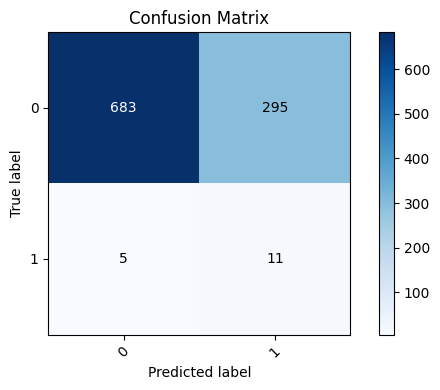


Accuracy: 69.82% 

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       978
           1       0.04      0.69      0.07        16

    accuracy                           0.70       994
   macro avg       0.51      0.69      0.44       994
weighted avg       0.98      0.70      0.81       994



In [24]:
evaluateModel(test_model['fraud_flag_transformed'], test_model['predicted_fraud'])

# it is not so conservative in predicting the frauds as Tree Based Models
# but it predicted more true positives than false positives which was not observed for tree-based models
# Overall accuracy is worse than tree-based models but i think this approach has more potential
# tuning the thresholds could be done
# also the Linear Programming Model could be joined with Reinforcement Learning to make it more robust
# so when the model is wrong then the value in the dictionary is updated